In [1]:
#load data (displacement and images)
import os
import cv2
import numpy as np
import pandas as pd

#load bead images
cell = "Cell_6"
dataDir = f"/home/local2/FTTC/Code/Traction_LSTM/Trial_4/{cell}"

displacements = []
images = []

for folderName in sorted(os.listdir(dataDir)):
    # print(f"Processing folder: {folderName}")
    folderPath = os.path.join(dataDir, folderName)
    if not os.path.isdir(folderPath):
        continue
    # if(folderPath!="/home/local2/FTTC/Code/Traction_LSTM/Trial_4/Cell_6/Cell1"):
    #     continue
    beadRefFile = os.path.join(folderPath, "cropCell200002.bmp.tif")
    beadDeformedFile = os.path.join(folderPath, "cropCell200001.bmp.tif")
    displacementFile = os.path.join(folderPath, "displacement.csv")

    brdata = cv2.imread(beadRefFile, cv2.IMREAD_GRAYSCALE)
    bddata = cv2.imread(beadDeformedFile, cv2.IMREAD_GRAYSCALE)
    dispData = pd.read_csv(displacementFile, header=0)

    images.append([brdata, bddata])
    displacements.append(dispData)


 
    
images_array = np.array(images)
print(f"images_array shape: {images_array.shape}")
images = np.rollaxis(images_array, 1, 4)
displacements_array = np.array(displacements)
print(f"images_array shape: {images_array.shape}")
print(f"displacements_array shape: {displacements_array.shape}")
  
print("Done!")           

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f908c736a50>>
Traceback (most recent call last):
  File "/home/local2/anaconda3/envs/opencv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


images_array shape: (294, 2, 288, 288)
images_array shape: (294, 2, 288, 288)
displacements_array shape: (294, 1295, 2)
Done!


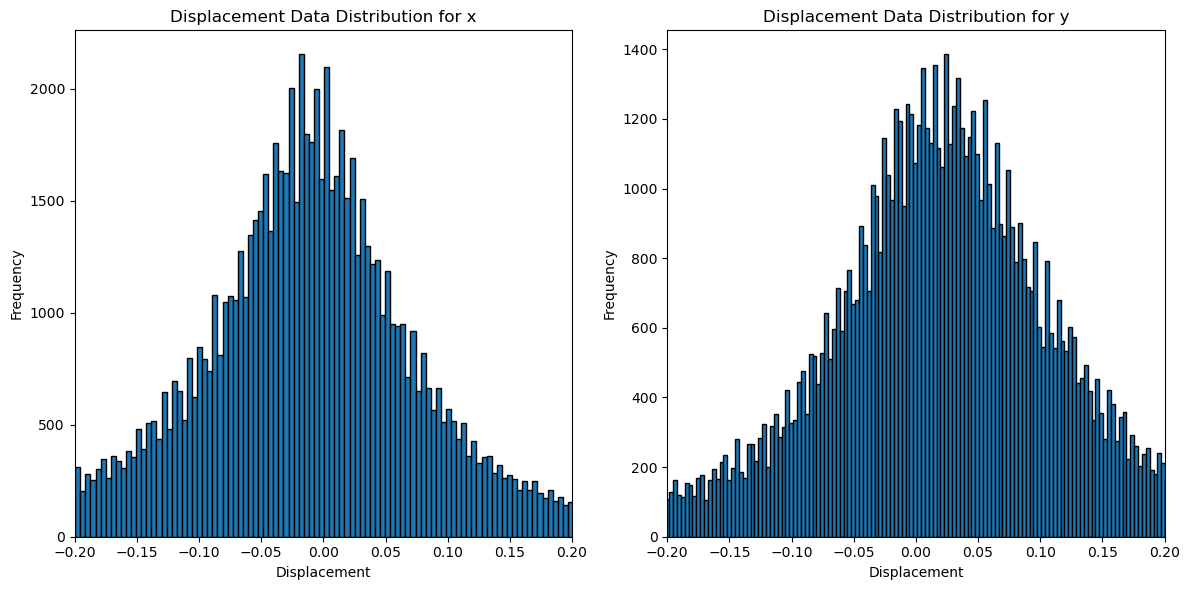

In [7]:
import matplotlib.pyplot as plt

# Create histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # first subplot
plt.hist(displacements_array[:, 0], bins=10000, edgecolor='black')
plt.title('Displacement Data Distribution for x')
plt.xlabel('Displacement')
plt.ylabel('Frequency')
# plt.xlim(-1,1)
plt.xlim(-0.2,0.2)

plt.subplot(1, 2, 2)  # second subplot
plt.hist(displacements_array[:, 1], bins=10000, edgecolor='black')
plt.title('Displacement Data Distribution for y')
plt.xlabel('Displacement')
plt.ylabel('Frequency')
plt.xlim(-0.2,0.2)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
#normalize data using min max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
displacements_array_normalized = scaler.fit_transform(displacements_array)
windows_array_normalized = scaler.fit_transform(images_array)

print("shape of displacements_array_normalized: ", displacements_array_normalized.shape)
print("shape of windows_array_normalized: ", windows_array_normalized.shape)

In [8]:

# Define your range
lower_bound = -0.2
upper_bound = 0.2

# # Create a boolean mask for the displacements in the desired range
# mask = (displacements_array[:, 0] >= lower_bound) & (displacements_array[:, 0] <= upper_bound)

# # Apply the mask to the displacements and windows
# filtered_displacements = displacements_array[mask]
# filtered_windows = windows_array[mask]

# print(f"filtered_displacements shape: {filtered_displacements.shape}")
# print(f"filtered_windows shape: {filtered_windows.shape}")

filtered_displacements shape: (79899, 2)
filtered_windows shape: (79899, 32, 32, 2)


In [9]:
#create training and testing data

train_windows =filtered_windows[:60000]
val_windows = filtered_windows[60000:]
train_displacements = filtered_displacements[:60000]
val_displacements =  filtered_displacements[60000:]

In [11]:
# #create training and testing data

# train_windows = windows_array[:75000]
# val_windows = windows_array[75000:]
# train_displacements = displacements_array[:75000]
# val_displacements =  displacements_array[75000:]


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# use strategy
strategy = tf.distribute.MirroredStrategy()

#create model
# Create the CNN model
with strategy.scope():
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(windowSize, windowSize,2)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(10))
    model.add(Dense(2))  # Output layer with 2 units for x and y displacements


    # Compile the model
    optim = Adam(learning_rate=0.00001)
    model.compile(optimizer=optim, loss='mean_squared_error')

    # Train the model
    model.fit(train_windows, train_displacements, validation_data=(val_windows, val_displacements), epochs=10, verbose=1)

# Save the model
model.save("./beadDisplacementPred_model.h5")


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/10


2024-03-29 19:05:00.817719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [75000,2]
	 [[{{node Placeholder/_11}}]]
2024-03-29 19:05:00.818470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [75000,2]
	 [[{{node Placeholder/_11}}]]
2024-03-29 19:05:00.898365: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:05:00.898802: I tensorflow/core/common_runtime/executor.c

2344/2344 [==============================] - ETA: 0s - loss: 0.7029

2024-03-29 19:12:15.967376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20256,2]
	 [[{{node Placeholder/_11}}]]
2024-03-29 19:12:15.967779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20256,2]
	 [[{{node Placeholder/_11}}]]
2024-03-29 19:12:16.040338: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:12:16.040740: I tensorflow/core/common_runtime/executor.c

2344/2344 [==============================] - 440s 187ms/step - loss: 0.7029 - val_loss: 0.3890
Epoch 2/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4524

2024-03-29 19:19:21.315311: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:19:21.315931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 425s 181ms/step - loss: 0.4524 - val_loss: 0.3652
Epoch 3/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4457

2024-03-29 19:26:30.716565: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:26:30.716992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 429s 183ms/step - loss: 0.4457 - val_loss: 0.3601
Epoch 4/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4441

2024-03-29 19:33:37.430990: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:33:37.431429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 426s 182ms/step - loss: 0.4441 - val_loss: 0.3589
Epoch 5/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4436

2024-03-29 19:40:43.960960: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:40:43.961410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 428s 182ms/step - loss: 0.4436 - val_loss: 0.3586
Epoch 6/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4433

2024-03-29 19:47:52.764777: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:47:52.765232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 428s 183ms/step - loss: 0.4433 - val_loss: 0.3588
Epoch 7/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4431

2024-03-29 19:54:58.989377: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 19:54:58.989912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 427s 182ms/step - loss: 0.4431 - val_loss: 0.3586
Epoch 8/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4428

2024-03-29 20:02:09.668378: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 20:02:09.668999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 430s 183ms/step - loss: 0.4428 - val_loss: 0.3588
Epoch 9/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4426

2024-03-29 20:09:17.155783: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 20:09:17.156338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 427s 182ms/step - loss: 0.4426 - val_loss: 0.3587
Epoch 10/10
2344/2344 [==============================] - ETA: 0s - loss: 0.4424

2024-03-29 20:16:25.869648: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-29 20:16:25.870099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]


2344/2344 [==============================] - 430s 183ms/step - loss: 0.4424 - val_loss: 0.3590


633/633 [==============================] - 4s 6ms/step
Actual: [-0.0160077 -0.112424 ], Predicted: [-0.34697944 -0.07815589], Error: [ 0.33097174 -0.03426811]
Actual: [0.0339923 0.0175764], Predicted: [0.31220812 0.2676109 ], Error: [-0.27821582 -0.25003451]
Actual: [0.00399226 0.0275764 ], Predicted: [-0.27936357  0.16329525], Error: [ 0.28335583 -0.13571885]
Actual: [ 0.0339923 -0.0224236], Predicted: [0.03725082 0.34571934], Error: [-0.00325852 -0.36814294]
Actual: [0.123992   0.00757636], Predicted: [ 0.06260974 -0.4078856 ], Error: [0.06138226 0.41546197]
Actual: [0.103992  0.0875764], Predicted: [-0.49187642 -0.3627305 ], Error: [0.59586842 0.4503069 ]
Actual: [-0.0660077  0.107576 ], Predicted: [0.15748057 0.10194734], Error: [-0.22348827  0.00562866]
Actual: [-0.0360077  0.207576 ], Predicted: [-0.2041009 -0.0476556], Error: [0.16809321 0.2552316 ]
Actual: [-0.256008   -0.00242364], Predicted: [-0.09653526  0.16010498], Error: [-0.15947274 -0.16252862]
Actual: [-0.140637   0.06

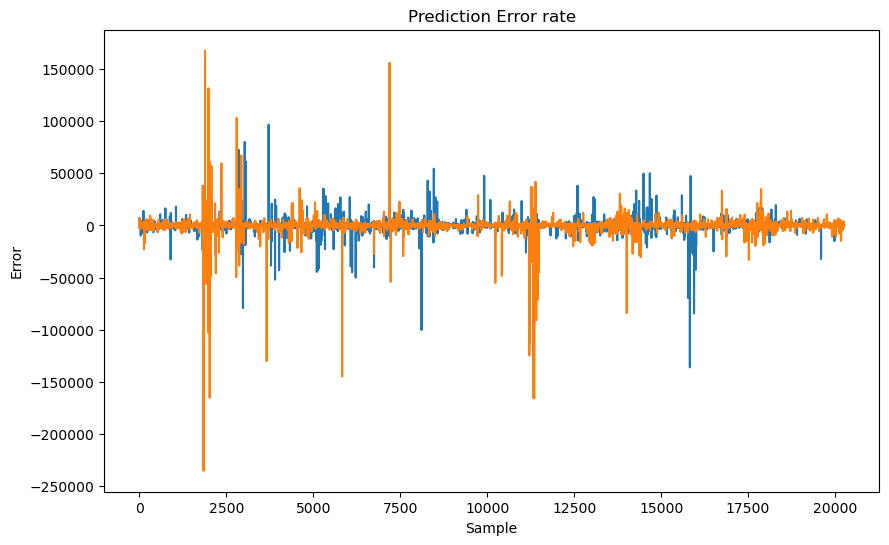

RMSE: 0.5627396484799503


In [11]:
import matplotlib.pyplot as plt
# Load the model
loadedModel = load_model("./beadDisplacementPred_model.h5")

# Predict the displacements using the trained model
val_predictions = loadedModel.predict(val_windows)

# Calculate the errors
errors = val_displacements - val_predictions

for i in range(0, 10):
    print(f"Actual: {val_displacements[i]}, Predicted: {val_predictions[i]}, Error: {errors[i]}")

errors_rate = (errors / val_displacements) * 100

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(errors_rate)
plt.title('Prediction Error rate')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.show()

# Calculate the RMSE
rmse = mean_squared_error(val_displacements, val_predictions, squared=False)
print(f"RMSE: {rmse}")